Documentation and explanation available [here](tinyurl.com/vgg16-dehaze-net)  
[Github Repository](https://github.com/sanchitvj/Image-Dehazing-using-vgg16-net)

In [ ]:
!pip install -q tensorflow_model_optimization

     |████████████████████████████████| 238 kB 17.2 MB/s 


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import copy

import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

from tensorflow_model_optimization.sparsity import keras as sparsity
import tensorflow_model_optimization as tfmot

# Preprocessing and loading of data

In [ ]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [ ]:
# function to get the path of individual image.

def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img

In [ ]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def Airlight(HazeImg, AirlightMethod, windowSize):
    if(AirlightMethod.lower() == 'fast'):
        A = []
        if(len(HazeImg.shape) == 3):
            for ch in range(len(HazeImg.shape)):
                kernel = np.ones((windowSize, windowSize), np.uint8)
                minImg = cv2.erode(HazeImg[:, :, ch], kernel)
                A.append(int(minImg.max()))
        else:
            kernel = np.ones((windowSize, windowSize), np.uint8)
            minImg = cv2.erode(HazeImg, kernel)
            A.append(int(minImg.max()))
    return(A)

def BoundCon(HazeImg, A, C0, C1, windowSze):
    if(len(HazeImg.shape) == 3):

        t_b = np.maximum((A[0] - HazeImg[:, :, 0].astype(np.float)) / (A[0] - C0),
                         (HazeImg[:, :, 0].astype(np.float) - A[0]) / (C1 - A[0]))
        t_g = np.maximum((A[1] - HazeImg[:, :, 1].astype(np.float)) / (A[1] - C0),
                         (HazeImg[:, :, 1].astype(np.float) - A[1]) / (C1 - A[1]))
        t_r = np.maximum((A[2] - HazeImg[:, :, 2].astype(np.float)) / (A[2] - C0),
                         (HazeImg[:, :, 2].astype(np.float) - A[2]) / (C1 - A[2]))

        MaxVal = np.maximum(t_b, t_g, t_r)
        transmission = np.minimum(MaxVal, 1)
    else:
        transmission = np.maximum((A[0] - HazeImg.astype(np.float)) / (A[0] - C0),
                         (HazeImg.astype(np.float) - A[0]) / (C1 - A[0]))
        transmission = np.minimum(transmission, 1)

    kernel = np.ones((windowSze, windowSze), np.float)
    transmission = cv2.morphologyEx(transmission, cv2.MORPH_OPEN, kernel=kernel)
    return(transmission)

def CalTransmission(HazeImg, Transmission, regularize_lambda, sigma):
    rows, cols = Transmission.shape

    KirschFilters = LoadFilterBank()

    # Normalize the filters
    for idx, currentFilter in enumerate(KirschFilters):
        KirschFilters[idx] = KirschFilters[idx] / np.linalg.norm(currentFilter)

    # Calculate Weighting function --> [rows, cols. numFilters] --> One Weighting function for every filter
    WFun = []
    for idx, currentFilter in enumerate(KirschFilters):
        WFun.append(CalculateWeightingFunction(HazeImg, currentFilter, sigma))

    # Precompute the constants that are later needed in the optimization step
    tF = np.fft.fft2(Transmission)
    DS = 0

    for i in range(len(KirschFilters)):
        D = psf2otf(KirschFilters[i], (rows, cols))
        DS = DS + (abs(D) ** 2)

    # Cyclic loop for refining t and u --> Section III in the paper
    beta = 1                    # Start Beta value --> selected from the paper
    beta_max = 2**8             # Selected from the paper --> Section III --> "Scene Transmission Estimation"
    beta_rate = 2*np.sqrt(2)    # Selected from the paper

    while(beta < beta_max):
        gamma = regularize_lambda / beta

        # Fixing t first and solving for u
        DU = 0
        for i in range(len(KirschFilters)):
            dt = circularConvFilt(Transmission, KirschFilters[i])
            u = np.maximum((abs(dt) - (WFun[i] / (len(KirschFilters)*beta))), 0) * np.sign(dt)
            DU = DU + np.fft.fft2(circularConvFilt(u, cv2.flip(KirschFilters[i], -1)))

        # Fixing u and solving t --> Equation 26 in the paper
        # Note: In equation 26, the Numerator is the "DU" calculated in the above part of the code
        # In the equation 26, the Denominator is the DS which was computed as a constant in the above code

        Transmission = np.abs(np.fft.ifft2((gamma * tF + DU) / (gamma + DS)))
        beta = beta * beta_rate
    return(Transmission)

def LoadFilterBank():
    KirschFilters = []
    KirschFilters.append(np.array([[-3, -3, -3],   [-3, 0, 5],   [-3, 5, 5]]))
    KirschFilters.append(np.array([[-3, -3, -3],   [-3, 0, -3],  [5, 5, 5]]))
    KirschFilters.append(np.array([[-3, -3, -3],   [5, 0, -3],   [5, 5, -3]]))
    KirschFilters.append(np.array([[5, -3, -3],    [5, 0, -3],   [5, -3, -3]]))
    KirschFilters.append(np.array([[5, 5, -3],     [5, 0, -3],   [-3, -3, -3]]))
    KirschFilters.append(np.array([[5, 5, 5],      [-3, 0, -3],  [-3, -3, -3]]))
    KirschFilters.append(np.array([[-3, 5, 5],     [-3, 0, 5],   [-3, -3, -3]]))
    KirschFilters.append(np.array([[-3, -3, 5],    [-3, 0, 5],   [-3, -3, 5]]))
    KirschFilters.append(np.array([[-1, -1, -1],   [-1, 8, -1],  [-1, -1, -1]]))
    return(KirschFilters)

def CalculateWeightingFunction(HazeImg, Filter, sigma):

    # Computing the weight function... Eq (17) in the paper

    HazeImageDouble = HazeImg.astype(float) / 255.0
    if(len(HazeImg.shape) == 3):
        Red = HazeImageDouble[:, :, 2]
        d_r = circularConvFilt(Red, Filter)

        Green = HazeImageDouble[:, :, 1]
        d_g = circularConvFilt(Green, Filter)

        Blue = HazeImageDouble[:, :, 0]
        d_b = circularConvFilt(Blue, Filter)

        WFun = np.exp(-((d_r**2) + (d_g**2) + (d_b**2)) / (2 * sigma * sigma))
    else:
        d = circularConvFilt(HazeImageDouble, Filter)
        WFun = np.exp(-((d ** 2) + (d ** 2) + (d ** 2)) / (2 * sigma * sigma))
    return(WFun)

def circularConvFilt(Img, Filter):
    FilterHeight, FilterWidth = Filter.shape
    assert (FilterHeight == FilterWidth), 'Filter must be square in shape --> Height must be same as width'
    assert (FilterHeight % 2 == 1), 'Filter dimension must be a odd number.'

    filterHalsSize = int((FilterHeight - 1)/2)
    rows, cols = Img.shape
    PaddedImg = cv2.copyMakeBorder(Img, filterHalsSize, filterHalsSize, filterHalsSize, filterHalsSize, borderType=cv2.BORDER_WRAP)
    FilteredImg = cv2.filter2D(PaddedImg, -1, Filter)
    Result = FilteredImg[filterHalsSize:rows+filterHalsSize, filterHalsSize:cols+filterHalsSize]

    return(Result)

##################
def psf2otf(psf, shape):
    """
    Convert point-spread function to optical transfer function.
    Compute the Fast Fourier Transform (FFT) of the point-spread
    function (PSF) array and creates the optical transfer function (OTF)
    array that is not influenced by the PSF off-centering.
    By default, the OTF array is the same size as the PSF array.
    To ensure that the OTF is not altered due to PSF off-centering, PSF2OTF
    post-pads the PSF array (down or to the right) with zeros to match
    dimensions specified in OUTSIZE, then circularly shifts the values of
    the PSF array up (or to the left) until the central pixel reaches (1,1)
    position.
    Parameters
    ----------
    psf : `numpy.ndarray`
        PSF array
    shape : int
        Output shape of the OTF array
    Returns
    -------
    otf : `numpy.ndarray`
        OTF array
    Notes
    -----
    Adapted from MATLAB psf2otf function
    """
    if np.all(psf == 0):
        return np.zeros_like(psf)

    inshape = psf.shape
    # Pad the PSF to outsize
    psf = zero_pad(psf, shape, position='corner')

    # Circularly shift OTF so that the 'center' of the PSF is
    # [0,0] element of the array
    for axis, axis_size in enumerate(inshape):
        psf = np.roll(psf, -int(axis_size / 2), axis=axis)

    # Compute the OTF
    otf = np.fft.fft2(psf)

    # Estimate the rough number of operations involved in the FFT
    # and discard the PSF imaginary part if within roundoff error
    # roundoff error  = machine epsilon = sys.float_info.epsilon
    # or np.finfo().eps
    n_ops = np.sum(psf.size * np.log2(psf.shape))
    otf = np.real_if_close(otf, tol=n_ops)

    return otf

def zero_pad(image, shape, position='corner'):
    """
    Extends image to a certain size with zeros
    Parameters
    ----------
    image: real 2d `numpy.ndarray`
        Input image
    shape: tuple of int
        Desired output shape of the image
    position : str, optional
        The position of the input image in the output one:
            * 'corner'
                top-left corner (default)
            * 'center'
                centered
    Returns
    -------
    padded_img: real `numpy.ndarray`
        The zero-padded image
    """
    shape = np.asarray(shape, dtype=int)
    imshape = np.asarray(image.shape, dtype=int)

    if np.alltrue(imshape == shape):
        return image

    if np.any(shape <= 0):
        raise ValueError("ZERO_PAD: null or negative shape given")

    dshape = shape - imshape
    if np.any(dshape < 0):
        raise ValueError("ZERO_PAD: target size smaller than source one")

    pad_img = np.zeros(shape, dtype=image.dtype)

    idx, idy = np.indices(imshape)

    if position == 'center':
        if np.any(dshape % 2 != 0):
            raise ValueError("ZERO_PAD: source and target shapes "
                             "have different parity.")
        offx, offy = dshape // 2
    else:
        offx, offy = (0, 0)

    pad_img[idx + offx, idy + offy] = image

    return pad_img

def removeHaze(HazeImg, Transmission, A, delta):
    '''
    :param HazeImg: Hazy input image
    :param Transmission: estimated transmission
    :param A: estimated airlight
    :param delta: fineTuning parameter for dehazing --> default = 0.85
    :return: result --> Dehazed image
    '''

    # This function will implement equation(3) in the paper
    # " https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf "

    epsilon = 0.0001
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    if len(HazeImg.shape) == 3:
        for ch in range(len(HazeImg.shape)):
            temp = ((HazeImg[:, :, ch].astype(float) - A[ch]) / Transmission) + A[ch]
            temp = np.maximum(np.minimum(temp, 255), 0)
            HazeCorrectedImage[:, :, ch] = temp
    else:
        temp = ((HazeImg.astype(float) - A[0]) / Transmission) + A[0]
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage = temp
    return(HazeCorrectedImage)

# Network Function

In [ ]:
def vgg16():
  model = Sequential()
  model.add(Conv2D(filters=64, 
                kernel_size=(3, 3), 
                padding='same', 
                activation='relu', 
                input_shape=(412,548,3), 
                name='conv1_1'))
  model.add(Conv2D(filters=64, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv1_2'))
  model.add(MaxPooling2D(pool_size=(2,2), 
                    strides=(2,2), 
                    name='max_pooling2d_1'))

  model.add(Conv2D(filters=128, 
                kernel_size=(3, 3), 
                padding='same', 
                activation='relu', 
                name='conv2_1'))
  model.add(Conv2D(filters=128, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv2_2'))
  model.add(MaxPooling2D(pool_size=(2,2), 
                  strides=(2,2), 
                  name='max_pooling2d_2'))

  model.add(Conv2D(filters=256, 
                kernel_size=(3, 3), 
                padding='same', 
                activation='relu', 
                input_shape=(412,548,3), 
                name='conv3_1'))
  model.add(Conv2D(filters=256, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv3_2'))
  model.add(Conv2D(filters=256, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv3_3'))  
  model.add(MaxPooling2D(pool_size=(2,2), 
                    strides=(2,2), 
                    name='max_pooling2d_3'))

  model.add(Conv2D(filters=512, 
                kernel_size=(3, 3), 
                padding='same', 
                activation='relu', 
                input_shape=(412,548,3), 
                name='conv4_1'))
  model.add(Conv2D(filters=512, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv4_2'))
  model.add(Conv2D(filters=512, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv4_3'))
  model.add(MaxPooling2D(pool_size=(2,2), 
                    strides=(2,2), 
                    name='max_pooling2d_4'))

  model.add(Conv2D(filters=512, 
                kernel_size=(3, 3), 
                padding='same', 
                activation='relu', 
                input_shape=(412,548,3), 
                name='conv5_1'))
  model.add(Conv2D(filters=512, 
                kernel_size=(3, 3), 
                    padding='same', 
                activation='relu',
                name='conv5_2'))
  model.add(Conv2D(filters=512, 
              kernel_size=(3, 3), 
                  padding='same', 
              activation='relu',
              name='conv5_3'))

  model.add(MaxPooling2D(pool_size=(2,2), 
                    strides=(2,2), 
                    name='max_pooling2d_5'))

  model.add(Flatten(name='flatten'))
  model.add(Dense(4096, activation='relu', name='fc_1'))
  model.add(Dropout(0.5, name='dropout_1'))
  model.add(Dense(4096, activation='relu', name='fc_2'))
  model.add(Dropout(0.5, name='dropout_4'))
  model.add(Dense(1000, activation='softmax', name='output'))
  # model.add(Reshape((412,548,3)))

  model.summary()
  # return Model(inputs=model.input, outputs=model.get_layer('output').output)
  return Model(inputs=model.input, outputs=model.input)


In [ ]:
# Hyperparameters and config
epochs = 1
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(orig_img_path = '/content/clear', hazy_img_path = '/content/hazy')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)

# for custom training loop
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [ ]:
# This model was originally trained using custom loop below in the notebook. For pruning purpose using .fit method to
# train 1 epoch.

vgg16 = vgg16()
vgg16.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error, metrics=['mse'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 412, 548, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 412, 548, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 206, 274, 64)     0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 206, 274, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 206, 274, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 137, 128)    0         
 2D)                                                    

In [ ]:
%%time
vgg16.fit(train, epochs = 1, validation_data=val)

1/1 [==============================] - 1s 589ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.0246 - val_mse: 0.0246
CPU times: user 669 ms, sys: 24.6 ms, total: 694 ms
Wall time: 874 ms


In [ ]:
vgg16.save_weights('baseline.h5')   # saving weights
vgg16.save('baseline')    # saving model

# Pruning

In [ ]:
# Pruning network by training it from scratch, takes little more time than unpruned network.

end_step = np.ceil(1.0 * 756 / 8).astype(np.int32) * epochs
# print(end_step)

# Pruning rate grows rapidly in the beginning from initial_sparsity, but then
#     plateaus slowly to the target sparsity. The function applied is
#     current_sparsity = final_sparsity + (initial_sparsity - final_sparsity)
#           * (1 - (step - begin_step)/(end_step - begin_step)) ^ exponent
# More details here: https://github.com/tensorflow/model-optimization/blob/c2642e5de64bb7709310bd7775de84b4765b359a/tensorflow_model_optimization/python/core/sparsity/keras/pruning_schedule.py#L183
new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,final_sparsity=0.90,begin_step=0,end_step=end_step,
                                                   frequency=100)}

# prune_low_magnitude() wrapes the tensorflow model with pruning functionality
new_pruned_model = sparsity.prune_low_magnitude(vgg16(), **new_pruning_params)
# new_pruned_model.summary()
net = new_pruned_model

net.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error, metrics=['mse'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 412, 548, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 412, 548, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 206, 274, 64)     0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 206, 274, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 206, 274, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 137, 128)    0         
 2D)                                                  

In [ ]:
%%time
import tensorflow_model_optimization
net.fit(train, epochs = 1, validation_data=val, callbacks=[tensorflow_model_optimization.sparsity.keras.UpdatePruningStep()])

1/1 [==============================] - 0s 407ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.0246 - val_mse: 0.0246
CPU times: user 578 ms, sys: 27.1 ms, total: 606 ms
Wall time: 423 ms


In [ ]:
net.save_weights('pruned.h5')
net.save('pruned')

In [ ]:
# Pruning network from pre-trained network.

end_step = np.ceil(1.0 * 756 / 8).astype(np.int32) * epochs
# print(end_step)

loaded_net = tf.keras.models.load_model('baseline')
pruning_saved_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,final_sparsity=0.90,begin_step=0,end_step=end_step,
                                                   frequency=100)}

pruning_saved_model = sparsity.prune_low_magnitude(loaded_net, **pruning_saved_params)
# new_pruned_model.summary()


pruning_saved_model.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error, metrics=['mse'])

In [ ]:
%%time
pruning_saved_model.fit(train, epochs = 1, validation_data=val, callbacks=[tensorflow_model_optimization.sparsity.keras.UpdatePruningStep()])

1/1 [==============================] - 0s 373ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.0246 - val_mse: 0.0246
CPU times: user 546 ms, sys: 7.58 ms, total: 553 ms
Wall time: 381 ms


In [ ]:
pruning_saved_model.save('pruned_saved_model')
pruning_saved_model.save_weights('pruned_saved_model.h5')

### Stripping the pruned network

In [ ]:
# Removing pruning wrappers added to network.

strip_prune = tfmot.sparsity.keras.strip_pruning(net)
strip_prune_saved = tfmot.sparsity.keras.strip_pruning(pruning_saved_model)
# stripe_prune.summary()

In [ ]:
strip_prune.save('striped')
strip_prune.save_weights('striped.h5')
strip_prune_saved.save('strip_prune_saved')
strip_prune_saved.save_weights('stripe_prune_saved.h5')

In [ ]:
# importing required modules
import zipfile
# code snippet available on docs
def get_gzipped_size(keras_file,zip_name):
    with zipfile.ZipFile(zip_name, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)

    return os.path.getsize(zip_name)

## Performance Evaluation by comparing sizes

In [ ]:
# Below code can be used to check the weights pruned
# for i, w in enumerate(model.get_weights()):
#     print(
#         "{} -- Total parameters:{}, Pruned %: {:.2f}%".format(
#             model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
#         )
#     )

In [ ]:
print("Size of gzipped baseline model: %.2f bytes" % (get_gzipped_size('./baseline', 'baseline_model.zip')))
print("Size of gzipped pruned model without stripping: %.2f bytes" % (get_gzipped_size('./pruned', 'pruned_model.zip')))
print("Size of gzipped pruned model with stripping: %.2f bytes" % (get_gzipped_size('./striped', 'striped_pruned_model.zip')))
print("Size of gzipped pretrained pruned model before stripping: %.2f bytes" % (get_gzipped_size('./pruned_saved_model','pruned_saved_model.zip')))
print("Size of gzipped pretrained pruned model after stripping: %.2f bytes" %(get_gzipped_size('./strip_prune_saved', 'strip_prune_saved.zip')))

Size of gzipped baseline model: 116.00 bytes
Size of gzipped pruned model without stripping: 112.00 bytes
Size of gzipped pruned model with stripping: 114.00 bytes
Size of gzipped pretrained pruned model before stripping: 136.00 bytes
Size of gzipped pretrained pruned model after stripping: 134.00 bytes


In [ ]:
print("Weight size of gzipped baseline model: %.2f bytes" % (get_gzipped_size('./baseline.h5', 'baseline_model_w.zip')))
print("Weight size of gzipped pruned model without stripping: %.2f bytes" % (get_gzipped_size('./pruned.h5', 'pruned_model_w.zip')))
print("Weight size of gzipped pruned model with stripping: %.2f bytes" % (get_gzipped_size('./striped.h5', 'striped_pruned_model_w.zip')))
print("Weight size of gzipped pretrained pruned model before stripping: %.2f bytes" % (get_gzipped_size('./pruned_saved_model.h5','pruned_saved_model_w.zip')))
print("Weight size of gzipped pretrained pruned model after stripping: %.2f bytes" %(get_gzipped_size('./stripe_prune_saved.h5', 'strip_prune_saved_w.zip')))

Weight size of gzipped baseline model: 588.00 bytes
Weight size of gzipped pruned model without stripping: 584.00 bytes
Weight size of gzipped pruned model with stripping: 586.00 bytes
Weight size of gzipped pretrained pruned model before stripping: 608.00 bytes
Weight size of gzipped pretrained pruned model after stripping: 608.00 bytes


## Original training function

In [ ]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
      
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [ ]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [=]  -  Training Loss: 0.0793  -  Validation Loss: 0.0000  -   Time taken: 0.31s
CPU times: user 459 ms, sys: 11.6 ms, total: 470 ms
Wall time: 520 ms


In [ ]:
def evaluate(net, test_img_path):
    
    test_img = glob.glob(test_img_path + '/*.jpg')
    random.shuffle(test_img)
    
    for img in test_img:
          # folder path
          dir_path = test_img_path
          output_f = "/content/test_output"
          if not os.path.exists(output_f):
            os.mkdir(output_f)

      # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
          loc = os.path.join(dir_path, path)
    
          HazeImg = cv2.imread(loc)

          # Resize image
          '''
          Channels = cv2.split(HazeImg)
          rows, cols = Channels[0].shape
          HazeImg = cv2.resize(HazeImg, (int(0.4 * cols), int(0.4 * rows)))
          '''

          # Estimate Airlight
          windowSze = 15
          AirlightMethod = 'fast'
          A = Airlight(HazeImg, AirlightMethod, windowSze)

          # Calculate Boundary Constraints
          windowSze = 3
          C0 = 20         # Default value = 20 (as recommended in the paper)
          C1 = 300        # Default value = 300 (as recommended in the paper)
          Transmission = BoundCon(HazeImg, A, C0, C1, windowSze)                  #   Computing the Transmission using equation (7) in the paper

          # Refine estimate of transmission
          regularize_lambda = 1       # Default value = 1 (as recommended in the paper) --> Regularization parameter, the more this  value, the closer to the original patch wise transmission
          sigma = 0.5
          Transmission = CalTransmission(HazeImg, Transmission, regularize_lambda, sigma)     # Using contextual information

          # Perform DeHazing
          HazeCorrectedImg = removeHaze(HazeImg, Transmission, A, 0.85)


          # cv2.imshow('Original', HazeImg)
          # cv2.imshow('Result', HazeCorrectedImg)
          # path = str(path)[:4]

          # print(path)
          cv2.waitKey(0)
          cv2.imwrite(f'/content/test_output/{path}', HazeCorrectedImg)

          
          display_list = [(plt.imread(dir_path + "/" + path)), plt.imread(output_f + "/" + path)]
          plt.figure(figsize = (80, 80))
              
          title = ['Hazy Image', 'Dehazed Image']

          for i in range(2):
              plt.subplot(1, 2, i+1)
              plt.title(title[i], fontsize = 65, y = 1.045)
              plt.imshow(display_list[i])
              plt.axis('off')
          
          plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for 

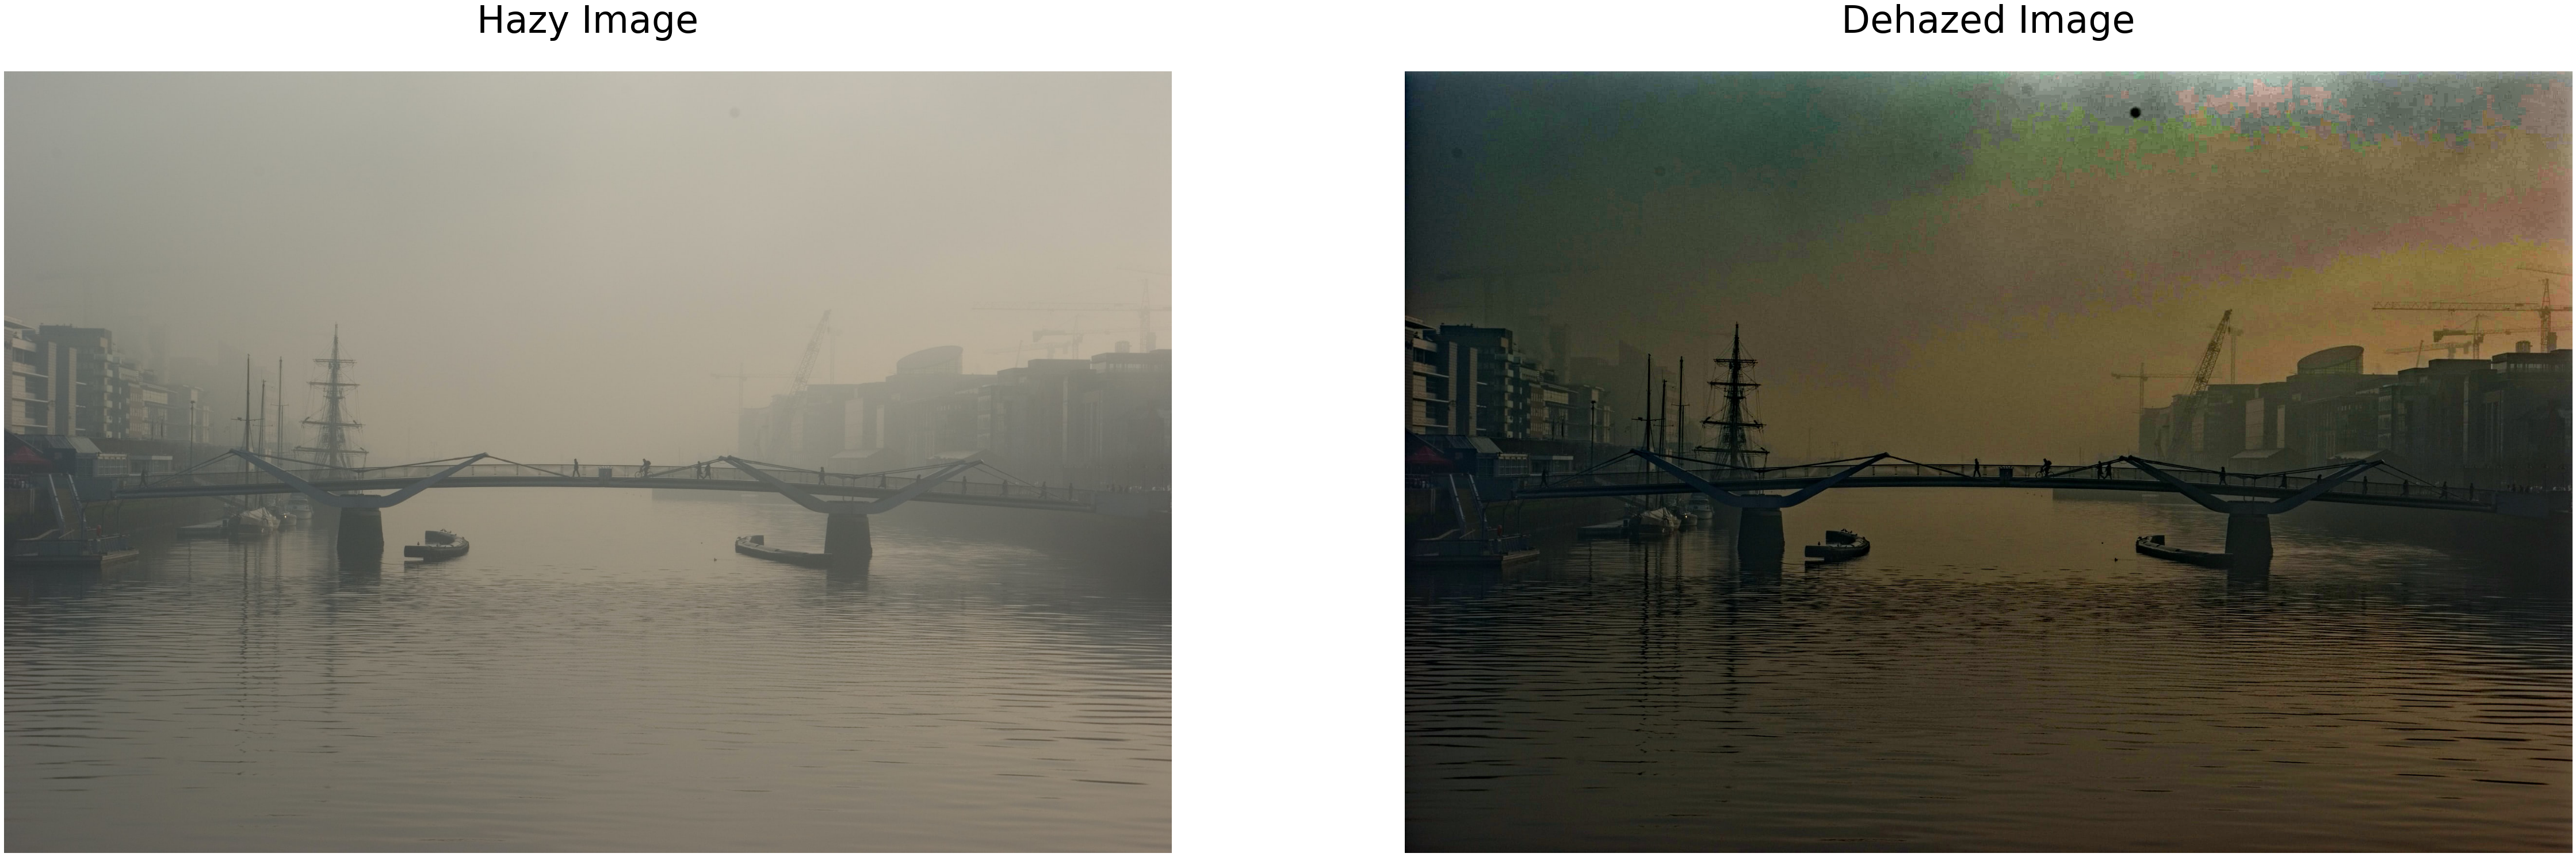

In [ ]:
test_net = tf.keras.models.load_model('trained_model', compile = False)
evaluate(test_net, '/content/test')